In [1]:
#| default_exp imgs_stats

# Statistics of images

In [2]:
#|hide
from nbdev.showdoc import *

In [26]:
#|export

import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from flood_exercise import utils_func
from flood_exercise import const_vals as CONST

In [20]:
#|export

class ImgsStatistics():

  def __init__(self,
      path_to_imgs : str , # path to the folder that contains the images
      ):
      
      # get the tiles paths
      self.list_of_files = utils_func.load_tif_paths(path_to_imgs)

      self.collect_results = {CONST.PATH_STR : [] , CONST.REGION_STR : []}

      for path in self.list_of_files:
         region = self._get_region_name_(path)
         self.collect_results[CONST.PATH_STR] = path
         self.collect_results[CONST.REGION_STR]=region

      self._img_statistics_(path)


  def _get_region_name_(self,
                        tile_name : str , # path of image , assuming that the first word in the file name is the region name
                        ):
     """
     Takes a string of images from the type "region_id_label.tif and extract the region name.
     for example, for "Bolivia_23014_S2Hand.tif" it will return Bolivia
     Parameters:
     folder_path (str): The path to the folder containing TIFF files.

     Returns:
     string: Name of the region , extracted from the tile name 
     """
     
     region = tile_name.split(CONST.SPLIT_TILES_NAMES_STR)[0]
     return region
  

  
  def _img_statistics_(self,
                       path : str , # path to image (tif file)
                       ):
     
     src = rasterio.open(path)
     src_arr = src.read()
     band_names = list(src.descriptions)

     self.bands_stats = {CONST.STR_BAND_NAME : [] , CONST.STR_MEAN : [] , CONST.STR_STD : [] }

     for band_name , index in zip(band_names,range(0,src.read().shape[0])):
        
        arr = src_arr[index,:,:]

        #convert 0 to nan , assuming 0 is no value and we don't want it to interrupt the staitistics
        arr = np.where(src_arr==0, np.nan, arr)

        #calculate mean
        mean = np.nanmean(arr)

        #calculate std
        std = np.nanstd(arr)

        self.bands_stats[CONST.STR_BAND_NAME] = band_name
        self.bands_stats[CONST.MEAN] = mean
        self.bands_stats[CONST.STD] = std






        
        

        

     

    


{'path': 'D:\\git\\flood_exercise\\S2\\USA_58086_S2Hand.tif',
 'region': 'D:\\git\\flood'}

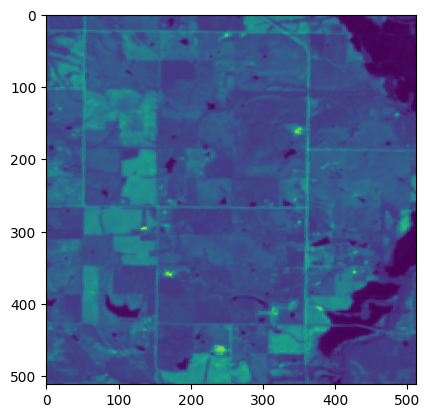

In [21]:
instance = ImgsStatistics(
  path_to_imgs = r'D:\git\flood_exercise\S2')

instance.collect_results

1029.3256912231445

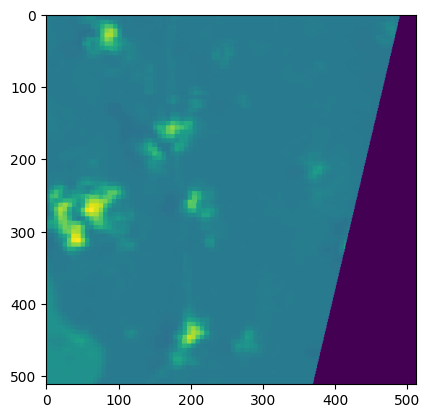

In [28]:
src=rasterio.open(r'D:\git\flood_exercise\S2\Bolivia_23014_S2Hand.tif')
band_names=list(rasterio.open(r'D:\git\flood_exercise\S2\Bolivia_23014_S2Hand.tif').descriptions)

src_arr = src.read()

plt.imshow(src_arr[0,:,:])
np.nanmean(src_arr[0,:,:])

In [33]:
src_arr[0,:,:]

array([[1208, 1211, 1211, ...,    0,    0,    0],
       [1208, 1211, 1211, ...,    0,    0,    0],
       [1206, 1218, 1218, ...,    0,    0,    0],
       ...,
       [1435, 1435, 1435, ...,    0,    0,    0],
       [1435, 1435, 1435, ...,    0,    0,    0],
       [1435, 1435, 1435, ...,    0,    0,    0]], dtype=int16)

In [34]:
np.mean(src_arr[0,:,:])

1029.3256912231445

In [40]:
np.nanmean(src_arr[0,:,:])

1226.4345925013522

In [38]:
src_arr = np.where(src_arr==0, np.nan, src_arr)
src_arr

array([[[1208., 1211., 1211., ...,   nan,   nan,   nan],
        [1208., 1211., 1211., ...,   nan,   nan,   nan],
        [1206., 1218., 1218., ...,   nan,   nan,   nan],
        ...,
        [1435., 1435., 1435., ...,   nan,   nan,   nan],
        [1435., 1435., 1435., ...,   nan,   nan,   nan],
        [1435., 1435., 1435., ...,   nan,   nan,   nan]],

       [[ 951.,  940.,  930., ...,   nan,   nan,   nan],
        [ 949.,  935.,  943., ...,   nan,   nan,   nan],
        [ 938.,  911.,  928., ...,   nan,   nan,   nan],
        ...,
        [1260., 1262., 1272., ...,   nan,   nan,   nan],
        [1263., 1271., 1271., ...,   nan,   nan,   nan],
        [1267., 1271., 1261., ...,   nan,   nan,   nan]],

       [[ 987.,  981.,  955., ...,   nan,   nan,   nan],
        [ 989.,  965.,  959., ...,   nan,   nan,   nan],
        [ 979.,  948.,  953., ...,   nan,   nan,   nan],
        ...,
        [1327., 1337., 1329., ...,   nan,   nan,   nan],
        [1335., 1331., 1331., ...,   nan,   n

In [16]:
for x , y in zip(band_names,range(0,src.read().shape[0])):
  print(x,y)

B1 0
B2 1
B3 2
B4 3
B5 4
B6 5
B7 6
B8 7
B8A 8
B9 9
B10 10
B11 11
B12 12
